In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings

from pandas_profiling import ProfileReport


warnings.filterwarnings('ignore')
pd.set_option('display.width', None)

C:\Users\thinkpad\anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\thinkpad\anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\thinkpad\anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [3]:
train = pd.read_csv("train.csv", parse_dates=['date'])
test = pd.read_csv("test.csv", parse_dates=['date'])
df = pd.concat([train, test], sort=False)

In [4]:
profile = ProfileReport(train, title="Pandas Profiling Report", explorative=True)
profile.to_file("your_report.html")


In [5]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [6]:
check_df(train)

##################### Shape #####################
(913000, 4)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object
##################### Head #####################
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
##################### Tail #####################
             date  store  item  sales
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82
##################### NA #####################
date     0
store    0
item     0
sales    0
dtype: int64
##################### Quantiles #####################
       0.00  0.05  0.50   0.95   0.99   1.00
store   1.0   1.0   5.5   10.0   10.0   10.0
item    1.0   3.0  25.5   48.0   50.0   50.0
sales   0.0  16.0  47.0  107.0  135.0  231.0


In [7]:
def outlier_thresholds(dataframe, col_name, q1_perc=0.05, q3_perc=0.95):
    """
    given dataframe, column name, q1_percentage and q3 percentage, function calculates low_limit and up_limit

    """
    quartile1 = dataframe[col_name].quantile(q1_perc)
    quartile3 = dataframe[col_name].quantile(q3_perc)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name, q1_perc=0.01, q3_perc=0.99):
    outlier_list = []
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1_perc=0.01, q3_perc=0.99)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True

    else:
        return False

In [8]:
check_outlier(df, 'sales')


False

In [9]:
print(df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]}))


               sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]


<Figure size 432x288 with 0 Axes>

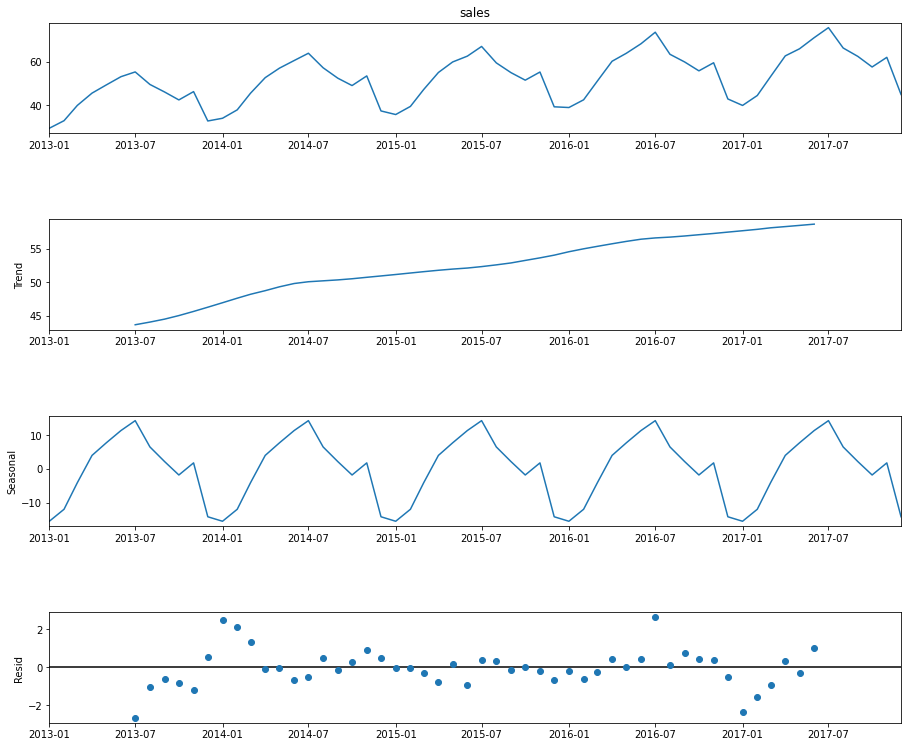

In [13]:
train_plot = train.set_index('date')
y = train_plot['sales'].resample('MS').mean() 

result = sm.tsa.seasonal_decompose(y, model='additive')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

In [14]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    # 1.1.2013 is Tuesday, so our starting point is the 2nd day of week
    df['day_of_week'] = df.date.dt.dayofweek + 1
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

In [15]:
df = create_date_features(df)
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,2,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,3,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,4,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,5,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,6,2013,1,0,0


In [16]:
def random_noise(dataframe):

    return np.random.normal(size=(len(dataframe),))

In [50]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)


In [51]:
def lag_features(dataframe, lags):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [52]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])



In [56]:
def roll_mean_features(dataframe, windows):
    dataframe = dataframe.copy()
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean())
    return dataframe

In [59]:
df = roll_mean_features(df_lagged, [365, 546, 730])
df.head(15)

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,...,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2013-01-06,1,1,12.0,NaN,1,6,6,1,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2013-01-07,1,1,10.0,NaN,1,7,7,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2013-01-08,1,1,9.0,NaN,1,8,8,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2013-01-09,1,1,12.0,NaN,1,9,9,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2013-01-10,1,1,9.0,NaN,1,10,10,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


In [61]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]
df = ewm_features(df, alphas, lags)
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,...,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,2,...,69.116907,51.309755,58.648702,64.033868,64.335072,80.828687,109.036310,71.734958,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,3,...,68.335072,57.154878,54.824351,65.516934,62.167536,85.414343,114.018155,65.867479,82.744506,68.466956
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,4,...,73.000522,58.077439,58.912176,68.758467,64.083768,94.207172,117.009078,69.433740,90.872253,71.733478
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,5,...,80.000156,66.038719,66.956088,70.379233,65.541884,96.603586,108.004539,68.716870,84.936127,77.366739
44999,2018-03-31,10,50,NaN,44999.0,3,31,90,13,6,...,81.400047,64.019360,68.478044,61.189617,67.270942,83.801793,103.002269,68.858435,90.968063,79.683369


In [62]:
df['sales'] = np.log1p(df["sales"].values)
df['sales'].head() 

0    2.639057
1    2.484907
2    2.708050
3    2.639057
4    2.397895
Name: sales, dtype: float64

In [63]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [65]:
train = df.loc[(df["date"] < "2017-01-01"), :]
train["date"].min(), train["date"].max()
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]
# columns with no useful information or with information that is already derived will be dropped.

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [66]:
Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

In [67]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 15000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [68]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)
# lgbtrain and lgbval's datatype is LightGBM Dataset

type(lgbtrain)

lightgbm.basic.Dataset

In [69]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=200)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.366625 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[200]	training's l1: 0.139587	training's SMAPE: 14.2999	valid_1's l1: 0.144267	valid_1's SMAPE: 14.8008
[400]	training's l1: 0.132309	training's SMAPE: 13.5711	valid_1's l1: 0.137636	valid_1's SMAPE: 14.135
[600]	training's l1: 0.130275	training's SMAPE: 13.3671	valid_1's l1: 0.135312	valid_1's SMAPE: 13.9014
[800]	training's l1: 0.12921	training's SMAPE: 13.2602	valid_1's l1: 0.133995	valid_1's SMAPE: 13.7687
[1000]	training's l1: 0.128516	training's SMAPE: 13.1909	valid_1's l1: 0.133286	valid_1's SMAPE: 13.6972
[1200]	training's l1: 0.127979	training's SMAPE: 13.1373	valid_1's l1: 0.13283	valid_1's SMAPE: 13.6512
[1400]	training's l1: 0.127602	training's SMAPE: 13.0996	valid_1's l1: 0.132481	valid_1's SMAPE: 13.6161
[1600]	training's l1: 0.127287	training's SMA

In [100]:
X_val.to_csv("flask_X_val_to_csv.csv",index=False)

In [99]:
X_val

,store,item,month,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,...,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
1461,1,1,1,1,1,52,7,1,1,0,...,14.659810,25.336195,26.033001,23.224180,24.695000,28.493284,23.083219,15.615928,31.842915,14.803870
1462,1,1,1,2,2,1,1,0,0,0,...,14.197943,22.668098,21.516501,21.112090,24.347500,25.246642,20.541610,13.807964,25.921458,14.401935
1463,1,1,1,3,3,1,2,0,0,0,...,10.559383,25.334049,19.758250,22.056045,24.173750,29.123321,21.770805,12.903982,24.960729,11.700967
1464,1,1,1,4,4,1,3,0,0,0,...,12.267815,21.167024,23.379125,23.528022,21.586875,31.561660,21.885402,12.451991,22.980364,12.350484
1465,1,1,1,5,5,1,4,0,0,0,...,16.280344,21.583512,25.689563,24.264011,20.793437,33.280830,28.942701,14.225995,27.990182,15.175242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912720,10,50,3,27,86,13,1,0,0,0,...,64.728704,62.255584,54.714690,56.480316,66.480395,82.744506,87.553505,78.735644,78.731022,64.636569
912721,10,50,3,28,87,13,2,0,0,0,...,62.118611,61.127792,56.357345,62.740158,60.740198,90.872253,94.276753,64.867822,71.865511,62.818285
912722,10,50,3,29,88,13,3,0,0,0,...,61.335583,52.063896,60.178672,57.870079,52.370099,84.936127,103.638376,68.933911,72.432756,61.909142
912723,10,50,3,30,89,13,4,0,0,0,...,72.300675,60.031948,58.089336,60.435039,51.685049,90.968063,113.319188,68.466956,75.216378,69.454571


In [70]:
y_pred_val = model.predict(X_val)
smape(np.expm1(y_pred_val), np.expm1(Y_val))



13.413953953144828

In [106]:
str(sum(y_pred_val))

'168027.8587431723'

In [72]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [73]:
loaded_model = pickle.load(open(filename, 'rb'))

In [103]:
y_pred_val = loaded_model.predict(X_val)
smape(np.expm1(y_pred_val), np.expm1(Y_val))


13.413953953144828

In [77]:
len(y_pred_val)

45000

In [88]:
val

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,...,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
1461,2017-01-01,1,1,2.995732,NaN,1,1,1,52,7,...,14.659810,25.336195,26.033001,23.224180,24.695000,28.493284,23.083219,15.615928,31.842915,14.803870
1462,2017-01-02,1,1,2.772589,NaN,1,2,2,1,1,...,14.197943,22.668098,21.516501,21.112090,24.347500,25.246642,20.541610,13.807964,25.921458,14.401935
1463,2017-01-03,1,1,2.397895,NaN,1,3,3,1,2,...,10.559383,25.334049,19.758250,22.056045,24.173750,29.123321,21.770805,12.903982,24.960729,11.700967
1464,2017-01-04,1,1,2.833213,NaN,1,4,4,1,3,...,12.267815,21.167024,23.379125,23.528022,21.586875,31.561660,21.885402,12.451991,22.980364,12.350484
1465,2017-01-05,1,1,2.708050,NaN,1,5,5,1,4,...,16.280344,21.583512,25.689563,24.264011,20.793437,33.280830,28.942701,14.225995,27.990182,15.175242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912720,2017-03-27,10,50,4.204693,NaN,3,27,86,13,1,...,64.728704,62.255584,54.714690,56.480316,66.480395,82.744506,87.553505,78.735644,78.731022,64.636569
912721,2017-03-28,10,50,4.110874,NaN,3,28,87,13,2,...,62.118611,61.127792,56.357345,62.740158,60.740198,90.872253,94.276753,64.867822,71.865511,62.818285
912722,2017-03-29,10,50,4.304065,NaN,3,29,88,13,3,...,61.335583,52.063896,60.178672,57.870079,52.370099,84.936127,103.638376,68.933911,72.432756,61.909142
912723,2017-03-30,10,50,4.234107,NaN,3,30,89,13,4,...,72.300675,60.031948,58.089336,60.435039,51.685049,90.968063,113.319188,68.466956,75.216378,69.454571


In [89]:
d = {"date": val["date"], "actual": Y_val, "predicted" : y_pred_val, "store" :val["store"], "item" : val["item"] }
results = pd.DataFrame(d).set_index('date')

In [90]:
results

,actual,predicted,store,item
date,,,,
2017-01-01,2.995732,2.973506,1,1
2017-01-02,2.772589,2.579639,1,1
2017-01-03,2.397895,2.731389,1,1
2017-01-04,2.833213,2.752716,1,1
2017-01-05,2.708050,2.765528,1,1
...,...,...,...,...
2017-03-27,4.204693,4.114419,10,50
2017-03-28,4.110874,4.279534,10,50
2017-03-29,4.304065,4.268635,10,50


In [92]:
results_1_1=results[(results["store"] == 1) & (results['item'] == 1)]

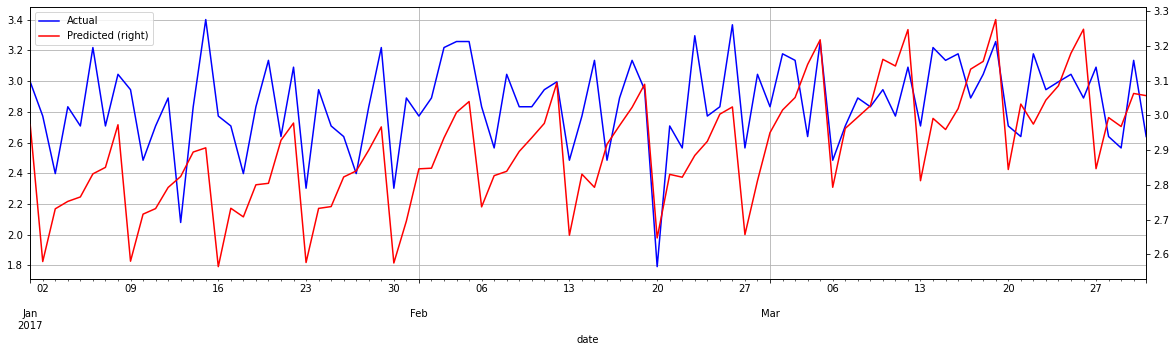

In [95]:
plt.figure(figsize=(20,5))
plt.xlabel('Actual-Predictid')

ax1 = results_1_1.actual.plot(color='blue', grid=True, label='Actual')
ax2 = results_1_1.predicted.plot(color='red', grid=True, secondary_y=True, label='Predicted')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1 + h2, l1 + l2, loc=2)
plt.show()

In [107]:
!pip freeze > requirements.txt
